# Diabetes Linear Regression example

This follows the linear regression tutorial in the [sci-kit documentation](http://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html), using the diabetes dataset, using a very simple Bayes model with two nodes. The diabetes dataset has around 10 features, but for this problem I've extracted a single variable and the target variable.

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
import sys
sys.path.append("../../../bayesianpy")

import bayesianpy
import pandas as pd
import logging
from sklearn.model_selection import train_test_split

# Load the diabetes dataset
diabetes = datasets.load_diabetes()

# Use only one feature
diabetes_X = diabetes.data[:, np.newaxis, 2]
df = pd.DataFrame({'A': [x[0] for x in diabetes_X], 'target': diabetes.target})

Let's see what the data actually looks like:

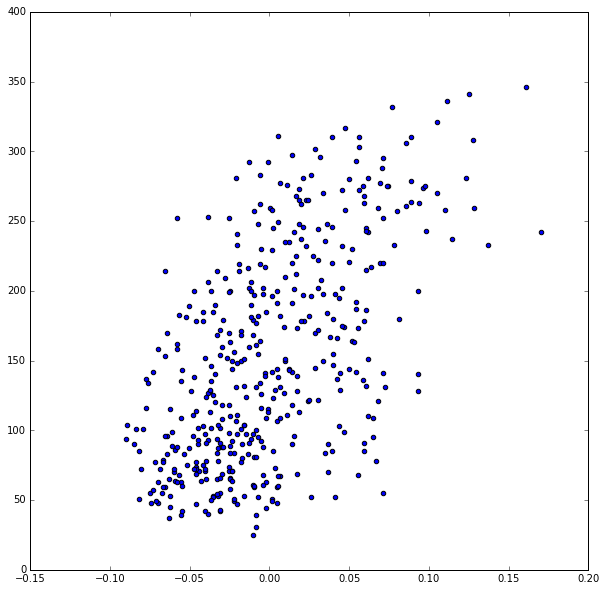

In [21]:
train, test = train_test_split(df, test_size=0.4)

logger = logging.getLogger()
bayesianpy.jni.attach(logger)
f = bayesianpy.utils.get_path_to_parent_dir('')
plt.figure(figsize=(10,10))
plt.scatter(df['A'].tolist(), df['target'].tolist(), label='Actual')
plt.show()

To create a linear regression model, only the target node and the node representing the input variable 'A' is required, with either the target node or 'A' as the parent (in this case). The template file has a number of basic templates, the naive Bayes template is one of the simpler templates and just creates edges between the parent target and each feature.

In [22]:
with bayesianpy.data.DataSet(df, f, logger) as dataset:
    tpl = bayesianpy.template.NaiveBayes('target', logger, continuous=df)
    model = bayesianpy.model.NetworkModel(tpl.create(bayesianpy.network
                                                     .NetworkFactory(logger)), logger)

    model.train(dataset.subset(train.index.tolist()))

Now to query the trained model with the test dataset. I'm interested in the mean value (as Bayes nets always give a variance with the prediction as well, which can indicate confidence in the output; the lower the variance, the more confident - or to put it another way the less conflicting information available).

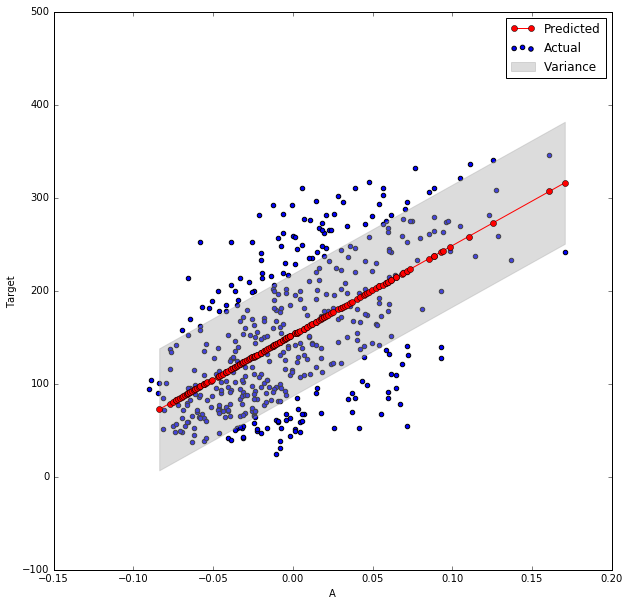

In [23]:
with bayesianpy.data.DataSet(df, f, logger) as dataset:
    results = model.batch_query(dataset.subset(test.index.tolist()),
                        [bayesianpy.model.QueryMeanVariance('target', output_dtype=df['target'].dtype)])

    results.sort_values(by='target_mean', ascending=True, inplace=True)
    plt.figure(figsize=(10,10))
    plt.scatter(df['A'].tolist(), df['target'].tolist(), label='Actual')
    plt.plot(results['A'], results['target_mean'], 'ro-', label='Predicted')
    plt.fill_between(results.A, results.target_mean-results.target_variance.apply(np.sqrt),
                     results.target_mean + results.target_variance.apply(np.sqrt), color='darkgrey', alpha=0.4,
                     label='Variance'
                     )
    plt.xlabel("A")
    plt.ylabel("Target")
    plt.legend()
    plt.show()

As a linear regressor, that looks quite reasonable, but what does it look like in real-terms (e.g. is a linear regression the most appropriate regression model to use here?). It's easy to visualise by plotting the residuals.

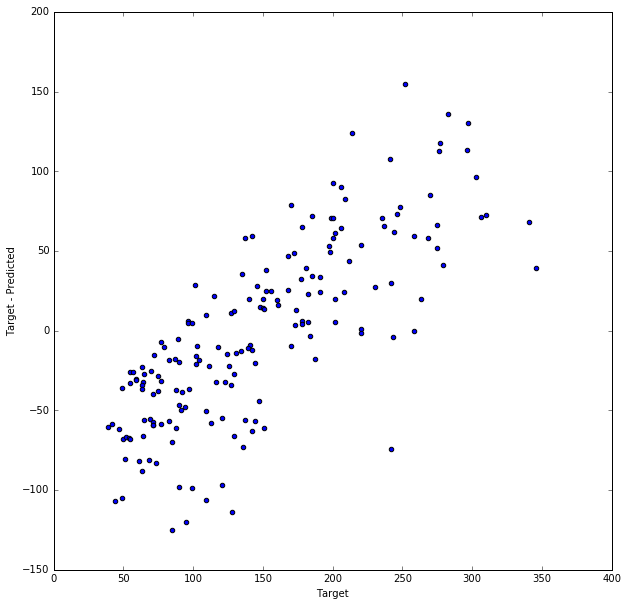

In [24]:
plt.figure(figsize=(10,10))

plt.scatter(results['target'], results['target']-results['target_mean'])
plt.xlabel('Target')
plt.ylabel('Target - Predicted')
plt.show()

Examining the residuals plot, it's possible to identify a pattern, and come to the conclusion that there is another underlying feature that the linear regression is not accounting for. At this point, it would make sense to add a latent variable to the network to make additional regimes available to the model.